### Carregando as Bibliotecas

In [1]:
! pip install lightgbm
! pip install xgboost

In [2]:
import plotly_express as px
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from scipy import stats
import scipy
import seaborn as sns
import statsmodels
import statsmodels.stats.api as sms

In [3]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [4]:
# parâmetros dos gráficos para o arquivo
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
%matplotlib inline
plt.rcParams.update(params)

In [5]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

### Arquivos_EUA

In [6]:
X= pd.read_excel(r'X.xlsx')

In [7]:
output= pd.read_excel(r'ybio.xlsx', header=0)

In [8]:
X =X.fillna(0.001)

In [9]:
X.head(2)
# dado não normalizado

,pibe_capita,pibe_areae,pope_areae,pibe_GWe,GWe_pope
0,0.046529,1.739276,37.380099,0.001599,29.099337
1,0.074343,0.113787,1.530579,0.008958,8.298660


In [10]:
output.head(2)
# dado não normalizado

,bioSe
0,11193.4559
1,513.4767


### geotermica

In [11]:
# Divisão entre arquivos de treino e teste, com corte em 30%
X_train, X_test, y_train, y_test = train_test_split(X,output,test_size =0.2, random_state=1234)

In [12]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor(n_estimators=100)
model.fit(X_train, y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
                    max_features='auto', max_leaf_nodes=None,
                    min_impurity_decrease=0.0, min_impurity_split=None,
                    min_samples_leaf=1, min_samples_split=2,
                    min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
                    oob_score=False, random_state=None, verbose=0,
                    warm_start=False)

<AxesSubplot:>

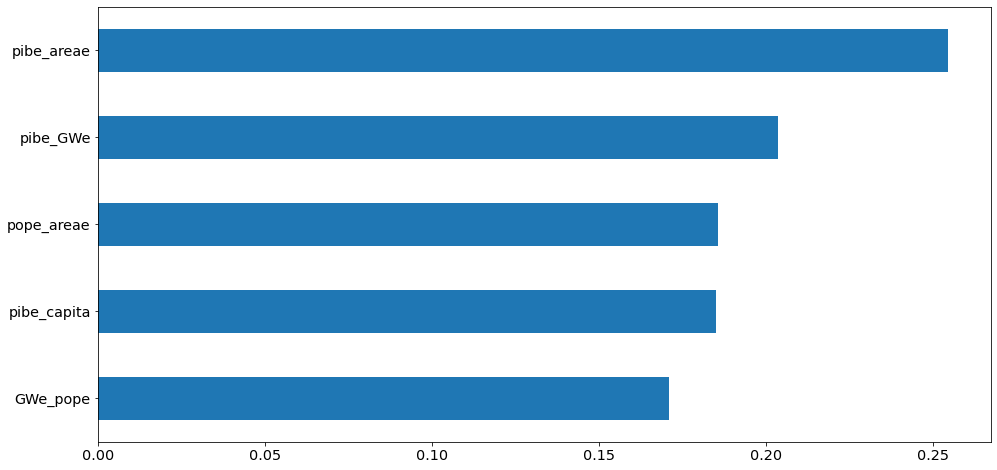

In [13]:
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(10).sort_values().plot.barh())

### Algoritmo Referência = Random Forest

In [14]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [15]:
# otimização de hiperparâmetros
params_grid= {'n_estimators':[2,3,4,5,6,7,8,9,10,11,12],
              "max_features":['auto'],
              'max_depth':[5,10,20,30],
              'max_leaf_nodes':[2,3,4,5],
              'min_samples_leaf':[5,10,15],
              'min_samples_split':[3,6,9,12,15,18,21]}
random_rf = RandomizedSearchCV(estimator = rf,cv=10,param_distributions=params_grid,n_iter=100,verbose=2,n_jobs=-1)
random_rf.fit(X_train, y_train)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.4s finished


RandomizedSearchCV(cv=10, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_st...


In [16]:
random_rf.best_params_

{'n_estimators': 7,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_leaf_nodes': 2,
 'max_features': 'auto',
 'max_depth': 20}

In [17]:
m_rf=RandomForestRegressor(n_estimators= 7,
 min_samples_split = 6,
 min_samples_leaf = 5,
 max_leaf_nodes = 2,
 max_features ='auto',
 max_depth = 20)

In [18]:
yrf = m_rf.fit(X_train,y_train)
print(yrf)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=20,
                      max_features='auto', max_leaf_nodes=2,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=5, min_samples_split=6,
                      min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=None,
                      oob_score=False, random_state=None, verbose=0,
                      warm_start=False)


In [19]:
y_rf= yrf.predict(X_test)

### Avaliação dos Erros

In [20]:
from sklearn.metrics import r2_score 
from sklearn.metrics import mean_squared_error # MSE
# RMSE = mean_squared_error(y_test,y_pred,squared=False) 
from sklearn.metrics import mean_absolute_error
import numpy as np
# MAPE = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
from sklearn.metrics import mean_squared_log_error

In [21]:
c=np.mean(y_train)
print(round(c,3))
# dados normalizados: entre 0 e 1

bioSe    8300.58
dtype: float64


In [22]:
R2 = r2_score(y_test,y_rf)
mse_rf = mean_squared_error(y_test, y_rf)
rmse_rf = mse_rf**0.5
mae_rf =  mean_absolute_error(y_test, y_rf)
# msle_rf = mean_squared_log_error(y_test,y_rf)
print('R2 =', round(R2,3))
print('MSE =', round(mse_rf,3))
print('RMSE =', round(rmse_rf,3))
print('MAE = ', round(mae_rf,3))
# print('MSLE =', round(msle_rf,3))

R2 = -0.07
MSE = 32796362.37
RMSE = 5726.811
MAE =  4843.807


In [23]:
# R2 ajustado -- ponderação entre os fatores mais relevantes
def adjusted_r2(y_test, y_rf,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_rf)) * (len(y_test) - 1)) / 
          (len(y_test) - X_train.shape[1] - 1))
    return adj_r2
a= round(adjusted_r2(y_test,y_rf,X_train),3)
print(a)

-1.407


In [24]:
y_test=np.array(y_test)

In [25]:
errop2= (y_test - y_rf)*100/y_test
# em porcentagem
media = round(np.mean(errop2),1)
print(media)
desvio = round(np.std(errop2),1)
print(desvio)

-432.2
694.6


In [26]:
a=np.mean(y_train) #teste média y_train
a
a = [a]*len(y_test)

In [27]:
# novo erro: modelo simples, com a média do conjunto treino
mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_rf = mse_rf/mse_m
print(round(mse_m,3), round(mse_rf,3))
print(round(r_rf,3))

33009481.403 32796362.37
0.994


### Uso inicial dos algoritmos GBoosting

### Otimização de parâmetros

In [28]:
# Light & XG Boosting
params= {
    'booster': ["gbtree","gblinear",'dart'],
    'learning rate': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max depth': [3,4,5,8,10,11,12],
    'min_child_weigth': [1,3,5,7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3,0.4,0.5,0.6]
}

In [29]:
# Gradient Boosting
params0= {
    'min_samples_split': [300,400,500],
    'min_samples_leaf': [30,40,50],
    'min_weight_fraction_leaf': [0, 0.1, 0.2, 0.3, 0.4],
    'max_depth': [5,6,7,8],
    'subsample': [0.6,0.7,0.8],
    'learning_rate' : [0.001, 0.01, 0.09, 0.1, 0.15]
}

In [30]:
# Adaptative Boosting
params1= {
    'n_estimators': [30,40,50],
    'learning_rate' : [0.001, 0.01, 0.09, 0.1, 0.15]
}

In [31]:
# GradientBoosting - Regressao
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(random_state=0)
gbr.fit(X_train, y_train)
import lightgbm as lgb
lgb = lgb.LGBMRegressor(learning_rate = 0.001, 
                              num_leaves = 65,  
                              n_estimators = 100)                       
lgb.fit(X_train, y_train)
 # XGBoost
import xgboost as xgb
xgb= xgb.XGBRegressor(learning_rate=0.001,
                            max_depth = 1, 
                            n_estimators = 100)
xgb.fit(X_train, y_train)
# AdaBoost
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
ada = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=1), n_estimators=100,
    learning_rate=0.001)
ada.fit(X_train, y_train)

print('*****************Regressao_pronta*****************')

*****************Regressao_pronta*****************


In [32]:
# Random Search & Cross Validation
random_search_gbr = RandomizedSearchCV(gbr,param_distributions=params0,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_lgb = RandomizedSearchCV(lgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_xgb = RandomizedSearchCV(xgb,param_distributions=params,n_iter=5,n_jobs=-1,cv=5,verbose=3)
random_search_ada = RandomizedSearchCV(ada,param_distributions=params1,n_iter=5,n_jobs=-1,cv=5,verbose=3)

In [33]:
random_search_gbr.fit(X_train, y_train)
random_search_lgb.fit(X_train, y_train)
random_search_xgb.fit(X_train, y_train)
random_search_ada.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  19 out of  25 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  25 | elapsed:    0.0s remaining:    0.1s


[17:52:40] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, learning rate, max depth, max_delta_step, max_depth, min_child_weight, min_child_weigth, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                                                    max_depth=1,
                                                                                    max_features=None,
                                                                                    max_leaf_nodes=None,
                                                                                    min_impurity_decrease=0.0,
                                                                                    min_impurity_split=None,
                                                                                    min_samples_leaf=1,
                                                                                    min_samples_split=2,
                                                                                    min_weight_fraction_lea

In [34]:
from sklearn.model_selection import cross_val_score
score_gbr=cross_val_score(gbr,X,output,cv=10)
score_lgb=cross_val_score(lgb,X,output,cv=10)
score_xgb=cross_val_score(xgb,X,output,cv=10)
score_ada=cross_val_score(ada,X,output,cv=10)

### Gradient Boosting

In [35]:
print(random_search_gbr.best_estimator_)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=30, min_samples_split=400,
                          min_weight_fraction_leaf=0.4, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)


In [36]:
m_gbr = GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth= 5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [37]:
m_gbr.fit(X_train,y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.01, loss='ls', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=400,
                          min_weight_fraction_leaf=0.1, n_estimators=100,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.7, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [38]:
y_gbr = m_gbr.predict(X_test)

In [39]:
mse_gbr = round(mean_squared_error(y_test, y_gbr),3)
print(mse_gbr)

33028924.751


In [40]:
errop2= (y_test - y_gbr)*100/y_test
a = np.mean(errop2)
print(round(a,3))
# em porcentagem

-521.003


In [41]:
R2 = r2_score(y_test,y_gbr)
mse_gbr = mean_squared_error(y_test, y_gbr)
rmse_gbr = mse_gbr**0.5
mae_gbr =  mean_absolute_error(y_test, y_gbr)
# msle_rf = mean_squared_log_error(y_test,y_rf)
print('R2 =', round(R2,3))
print('MSE =', round(mse_gbr,3))
print('RMSE =', round(rmse_gbr,3))
print('MAE = ', round(mae_gbr,3))
# print('MSLE =', round(msle_rf,3))

R2 = -0.077
MSE = 33028924.751
RMSE = 5747.08
MAE =  5053.957


In [42]:
def adjusted_r2(y_test, y_gbr,X_train):
    from sklearn.metrics import r2_score
    adj_r2 = (1 - ((1 - r2_score(y_test, y_gbr)) * (len(y_test) - 1)) / 
          (len(y_test) - X_train.shape[1] - 1))
    return adj_r2
c = round(adjusted_r2(y_test,y_gbr,X_train),3)
print(c)

-1.424


In [43]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_gbr = mse_gbr/mse_m
print(round(mse_m,3), round(mse_gbr,3))
print(round(r_gbr,3))

33009481.403 33028924.751
1.001


### Light Gradient Boosting

In [44]:
print(random_search_lgb.best_estimator_)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.3, gamma=0.4, importance_type='split',
              learning rate=0.5, learning_rate=0.001, max depth=5, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_child_weigth=7,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)


In [45]:
from lightgbm import LGBMRegressor
m_lgb = LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0.1 ,importance_type='split',
              learning_rate=0.001, max_depth=12,
              min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=65,
              objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

In [46]:
m_lgb.fit(X_train,y_train)

LGBMRegressor(booster='dart', boosting_type='gbdt', class_weight=None,
              colsample_bytree=0.4, gamma=0.1, importance_type='split',
              learning_rate=0.001, max_depth=12, min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_leaves=65, objective=None, random_state=None,
              reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [47]:
y_lgb = m_lgb.predict(X_test)

In [48]:
mse_lgb = round(mean_squared_error(y_test, y_lgb),3)
print(mse_lgb)

33009481.563


In [49]:
errop2= (y_test - y_lgb)*100/y_test
# em porcentagem

In [50]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_lgb = mse_lgb/mse_m
print(round(mse_m,3), round(mse_lgb,3))
print(round(r_lgb,3))

33009481.403 33009481.563
1.0


### XGBoosting

In [51]:
print(random_search_xgb.best_estimator_)

XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning rate=0.4, learning_rate=0.001, max depth=10,
             max_delta_step=0, max_depth=1, min_child_weight=1,
             min_child_weigth=3, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


In [82]:
from xgboost import XGBRegressor
m_xgb_1= XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1.3,
             max_delta_step=0, max_depth=1, min_child_weight=3,
             missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [83]:
m_xgb_1.fit(X_train,y_train)

[17:55:38] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { colsample_bylevel, colsample_bynode, colsample_bytree, gamma, interaction_constraints, max_delta_step, max_depth, min_child_weight, monotone_constraints, num_parallel_tree, subsample, tree_method } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gblinear', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.1, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=1.3, max_delta_step=0, max_depth=1,
             min_child_weight=3, missing=0.001, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [84]:
y_xgb= m_xgb_1.predict(X_test)

In [85]:
mse_xgb= round(mean_squared_error(y_test, y_xgb),3)
print (mse_xgb)

35238185.662


In [86]:
errop2= (y_test - y_xgb)*100/y_test
# em porcentagem

In [87]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_xgb= mse_xgb/mse_m
print(round(mse_m,3), round(mse_xgb,3))
print(round(r_xgb,3))

33009481.403 35238185.662
1.068


### Adaptative Boosting

In [88]:
print(random_search_ada.best_estimator_)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.001, loss='linear', n_estimators=30,
                  random

In [89]:
m_ada = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=50,
                  random_state=None)

In [90]:
m_ada.fit(X_train,y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse',
                                                       max_depth=1,
                                                       max_features=None,
                                                       max_leaf_nodes=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fraction_leaf=0.0,
                                                       presort=False,
                                                       random_state=None,
                                                       splitter='best'),
                  learning_rate=0.15, loss='linear', n_estimators=50,
                  random_

In [91]:
y_ada = m_ada.predict(X_test)

In [92]:
mse_ada = round(mean_squared_error(y_test, y_ada),8)
print (mse_ada)

36790875.91415936


In [93]:
errop2= (y_test - y_ada)*100/y_test
# em porcentagem

In [94]:
# novo erro: modelo simples, com a média do conjunto treino
# mse_m = mean_squared_error(y_test,a)
# comparativo entre o modelo tree e o modelo simples
r_ada = mse_ada/mse_m
print(round(mse_m,3), round(mse_ada,3))
print(round(r_ada,3))

33009481.403 36790875.914
1.115


In [95]:
models=['Random_Forest','GradientBoost','LightGBM','XGBoost','AdaBoost']
mse=[mse_rf,mse_gbr,mse_lgb,mse_xgb,mse_ada]
r=[r_rf,r_gbr,r_lgb,r_xgb,r_ada]
lista = list(zip(mse,r))
d = pd.DataFrame(lista, columns =['MSE','Razão'], index=models)
d

,MSE,Razão
Random_Forest,3.279636e+07,0.993544
GradientBoost,3.302892e+07,1.000589
LightGBM,3.300948e+07,1.000000
XGBoost,3.523819e+07,1.067517
AdaBoost,3.679088e+07,1.114555


### Predição dados Brasil

### Composição do arquivo de saída¶

In [96]:
entb= pd.read_excel(r'Xb.xlsx', header=0)
entb.head(2)

,pibe_capita,pibe_areae,pope_areae,pibe_GWe,GWe_pope
0,0.015955,0.086953,5.449966,58.971074,0.000271
1,0.015767,1.897872,120.371637,8.881176,0.001775


In [97]:
# entb = np.array(entb)

In [98]:
outputb= m_xgb_1.predict(entb)
outputb

array([7989.2637, 6653.8086, 8161.5503, 8185.9585, 7872.6045, 7411.015 ,
       2576.909 , 7939.937 , 7958.7603, 8182.8164, 8130.7954, 7705.37  ,
       7387.0283, 7210.622 , 8156.3013, 6892.3213, 8068.1816, 2262.0417,
       7355.879 , 7609.479 , 8151.31  , 8086.159 , 7083.593 , 6810.757 ,
       5243.57  , 8168.4067], dtype=float32)

In [108]:
outb=pd.DataFrame(data=outputb, columns=['Prev'])
outb.head(2)

,Prev
0,7989.263672
1,6653.808594


In [111]:
br= pd.read_excel(r'br_estado.xlsx', header=0)
# indexação_por_estado_brasileiro

In [112]:
br=br.drop(columns=['PIB em 2017 (1.000.000 R$)','Área (km2)','Geração de energia GW.h','População'])
br.head(1)

,Unidades da Federação
0,Acre


In [113]:
br = br.rename({'Unidades da Federação': 'Estado'}, axis = 1)

In [118]:
br = pd.DataFrame(data=br)
br.head(2)

,Estado
0,Acre
1,Alagoas


In [119]:
prv = pd.concat([br, outb], axis=1, sort=False)

In [120]:
prv.head(30)

,Estado,Prev
0,Acre,7989.263672
1,Alagoas,6653.808594
2,Amapá,8161.550293
3,Amazonas,8185.958496
4,Bahia,7872.604492
5,Ceará,7411.015137
6,Espírito Santo,2576.908936
7,Goiás,7939.937012
8,Maranhão,7958.760254
9,Mato Grosso,8182.816406
